# Import necessary libraries


In [199]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error


# Load the dataset


In [231]:
# Load the dataset
file_path = 'ETTh1_without_missing.csv'
df = pd.read_csv(file_path)
df.head()


,Id,date,OT,Unnamed: 3
0,0,2016-07-01 00:00:00,30.531000,NaN
1,1,2016-07-01 01:00:00,27.787001,NaN
2,2,2016-07-01 02:00:00,27.787001,NaN
3,3,2016-07-01 03:00:00,25.044001,NaN
4,4,2016-07-01 04:00:00,21.948000,NaN


# Drop unnecessary columns and convert 'date' to datetime format


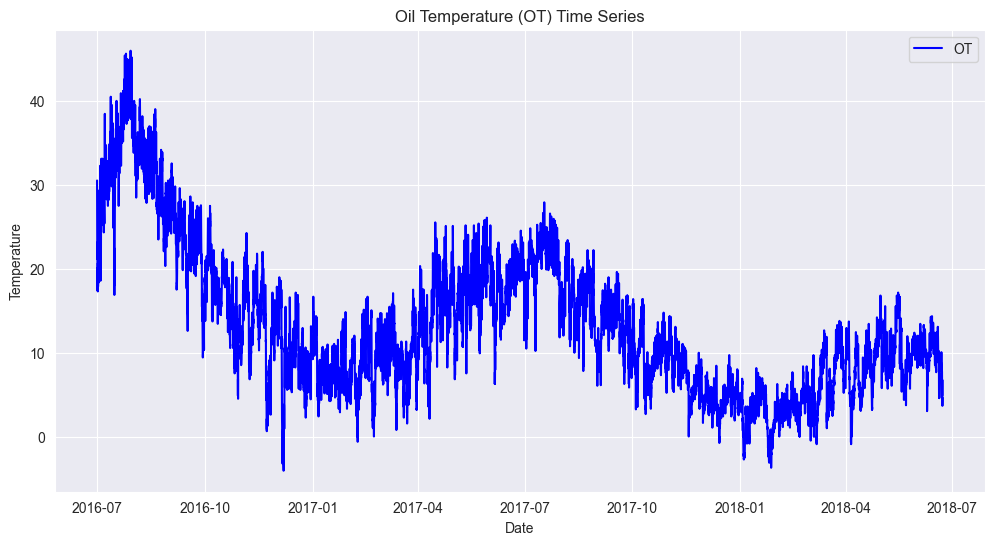

In [201]:
df.drop(['Id', 'Unnamed: 3'], axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index of the dataframe
df.set_index('date', inplace=True)
# Visualize the 'OT' time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['OT'], label='OT', color='blue')
plt.title('Oil Temperature (OT) Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#WE ARE PLOTTNG WITH A ROLLING TO SEE IF THERE'S A TREND AND DECIDED IF DATA'S SHOULD BE NORMALIZED OR NOT


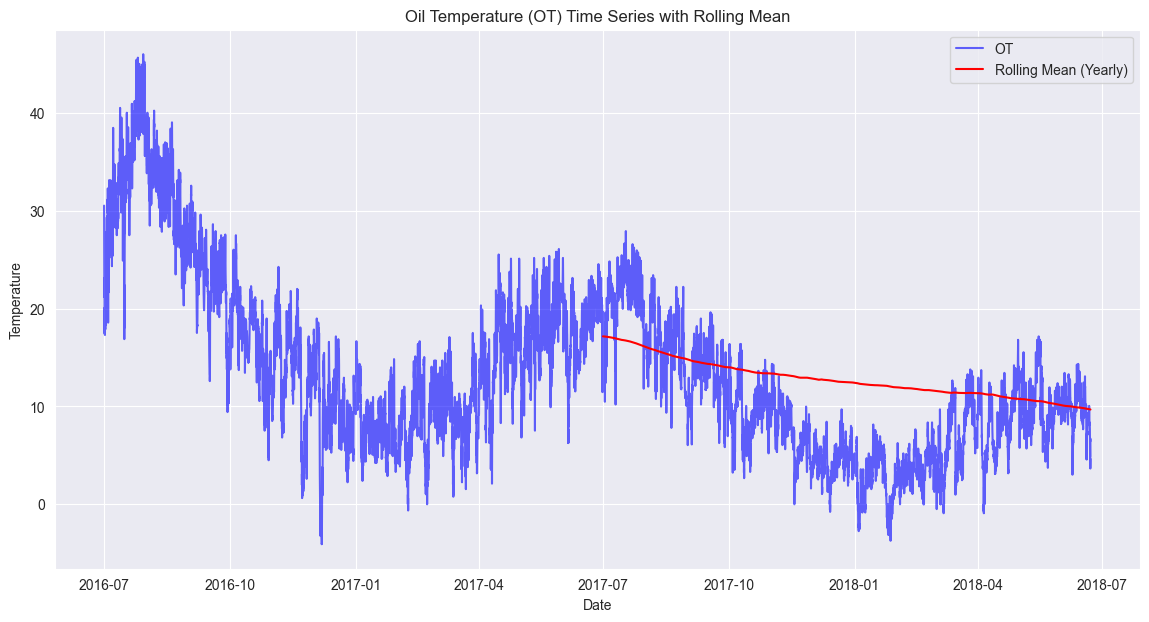

In [202]:
# Plotting the "OT" time series again with a rolling mean to identify trends
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['OT'], label='OT', color='blue', alpha=0.6)
plt.plot(df['OT'].rolling(window=365*24).mean(), label='Rolling Mean (Yearly)', color='red')
plt.title('Oil Temperature (OT) Time Series with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [203]:
# Normalize the 'OT' column
scaler = MinMaxScaler()
df['OT_normalized'] = scaler.fit_transform(df[['OT']])


In [233]:
df.tail(100)

,Id,date,OT,Unnamed: 3
17220,17220,2018-06-18 12:00:00,10.833,NaN
17221,17221,2018-06-18 13:00:00,11.185,NaN
17222,17222,2018-06-18 14:00:00,11.959,NaN
17223,17223,2018-06-18 15:00:00,13.085,NaN
17224,17224,2018-06-18 16:00:00,11.959,NaN
...,...,...,...,...
17315,17315,2018-06-22 11:00:00,6.753,NaN
17316,17316,2018-06-22 12:00:00,3.658,NaN
17317,17317,2018-06-22 13:00:00,3.658,NaN
17318,17318,2018-06-22 14:00:00,4.150,NaN


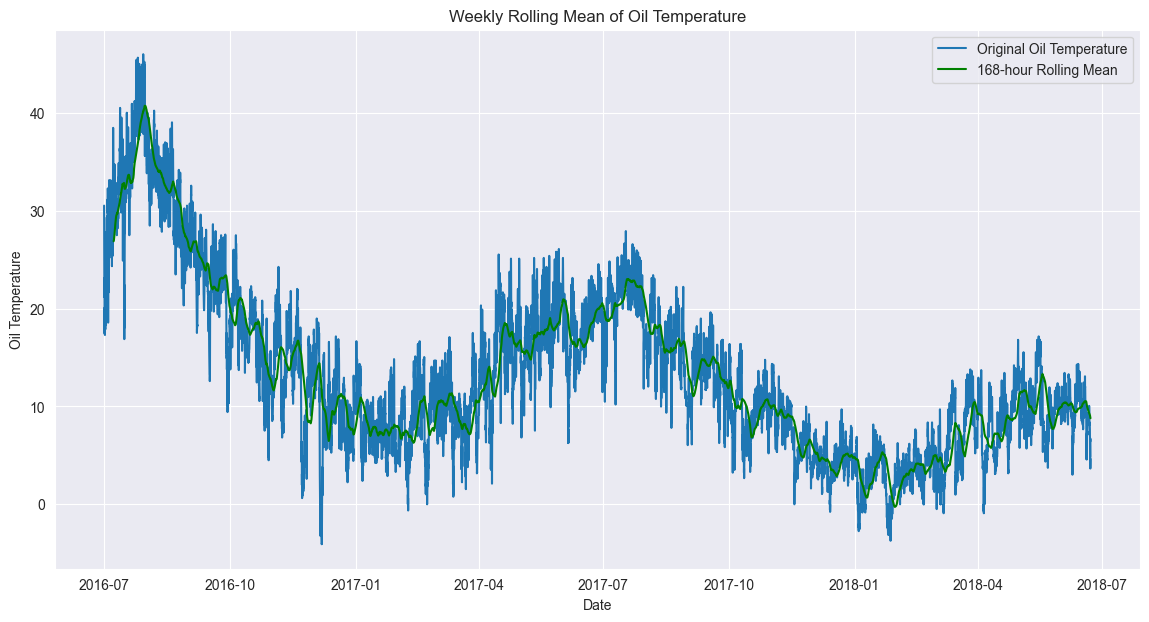

In [205]:
roll_mean_weekly = df['OT'].rolling(window=168).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['OT'], label='Original Oil Temperature')
plt.plot(roll_mean_weekly, color='green', label='168-hour Rolling Mean')
plt.title('Weekly Rolling Mean of Oil Temperature')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


In [206]:
 #Function to create sequences from the time series data
def create_sequences(input_data, window_size):
    X = []
    Y = []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:(i + window_size), 0])
        Y.append(input_data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [207]:
# Prepare sequences using the normalized 'OT' values
window_size = 5
X, Y = create_sequences(df[['OT_normalized']].values, window_size)

In [208]:

# Split the data into training and test sets (excluding the last 100 values for testing)
X_train = X[:-100]
Y_train = Y[:-100]
X_test = X[-100:]
Y_test = Y[-100:]

In [209]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [210]:
 #Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])

/Users/thiamaziz/Desktop/forecasting/forecasting/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [211]:
 #Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])


In [212]:

# (Optional) Print model summary to verify architecture
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
# Train the model
model.fit(X_train, Y_train, validation_split=0.1, epochs=20, batch_size=64)

Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0237 - root_mean_squared_error: 0.1387 - val_loss: 4.4024e-04 - val_root_mean_squared_error: 0.0210
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4660e-04 - root_mean_squared_error: 0.0308 - val_loss: 4.2739e-04 - val_root_mean_squared_error: 0.0207
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5325e-04 - root_mean_squared_error: 0.0292 - val_loss: 4.1018e-04 - val_root_mean_squared_error: 0.0203
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1237e-04 - root_mean_squared_error: 0.0285 - val_loss: 4.1767e-04 - val_root_mean_squared_error: 0.0204
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9125e-04 - root_mean_squared_error: 0.0281 - val_loss: 3.6200e-04 - val_root_mean_squared_error: 0.0190
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9529e-04 - root_mean_squared_error: 0.0264 - val_loss: 3.3893e-04 - val_root_mean_squared_error: 0.0184
Epoch 7/

In [214]:
# After training,evaluate the model
model.evaluate(X_test, Y_test) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2437e-04 - root_mean_squared_error: 0.0184 


[0.0005396137712523341, 0.018068397417664528]

In [215]:
model.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.28935927],
       [0.30213183],
       [0.31087875],
       [0.3249592 ],
       [0.34644434],
       [0.33088768],
       [0.32721853],
       [0.3274812 ],
       [0.32441828],
       [0.30330202],
       [0.29196584],
       [0.28981292],
       [0.29260403],
       [0.2851377 ],
       [0.2738966 ],
       [0.27178556],
       [0.26985726],
       [0.26840994],
       [0.270486  ],
       [0.27924144],
       [0.27889448],
       [0.27120632],
       [0.273952  ],
       [0.28218246],
       [0.28516734],
       [0.28987455],
       [0.28490758],
       [0.21412855],
       [0.1984736 ],
       [0.1839621 ],
       [0.19159177],
       [0.21658987],
       [0.22457758],
       [0.23040092],
       [0.1911307 ],
       [0.18874198],
       [0.20309144],
       [0.21770829],
       [0.23279592],
       [0.23025754],
       [0.23061845],
       [0.23080736],
       [0.23091933],
       [0.23425278],
       [0.23740709],
       [0.23235387],
       [0.23639369],
       [0.248

In [216]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0  # Set verbose to 1 or 2 to see the training progress
)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual Y_test values to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Prepare data for plotting
preds = predictions_inverse.flatten()
actuals = Y_test_inverse.flatten()

(preds[:10], actuals[:10])  # Display the first 10 predictions and actual values for comparison


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


(array([10.051427 , 10.759818 , 11.165165 , 11.899961 , 13.012548 ,
        12.024767 , 11.956959 , 11.997755 , 11.8167095, 10.664295 ],
       dtype=float32),
 array([10.83300018, 11.18500042, 11.95899963, 13.08500004, 11.95899963,
        12.02900028, 12.02900028, 11.81799984, 10.62199974, 10.19999981]))

In [240]:
test_dates = df.index[-100:]  # Assuming 'df' has 'date' set as its index

# Create a DataFrame for comparing predictions with actual values
comparison_df = pd.DataFrame({
    'date': test_dates,
    'Actual': actuals,  # 'actuals' needs to be defined previously
    'Predicted': preds  # 'preds' needs to be defined previously
})

# Display the DataFrame
comparison_df.to_csv('comparaison.csv',index=False)
comparison_df


,date,Actual,Predicted
0,17220,10.833,10.051427
1,17221,11.185,10.759818
2,17222,11.959,11.165165
3,17223,13.085,11.899961
4,17224,11.959,13.012548
...,...,...,...
95,17315,6.753,6.475428
96,17316,3.658,6.749117
97,17317,3.658,4.035531
98,17318,4.150,3.627685


In [242]:
# Selecting and renaming the columns
output_df = comparison_df[[ 'Predicted']].copy()
output_df.rename(columns={'Predicted': 'OT'}, inplace=True)

# Saving to CSV
output_file_path = 'predicted_ot.csv'  # Specifying the file path
output_df.to_csv(output_file_path, index=True)  # Saving the DataFrame to a CSV file without the index

# Display the file path for download
output_file_path


'predicted_ot.csv'

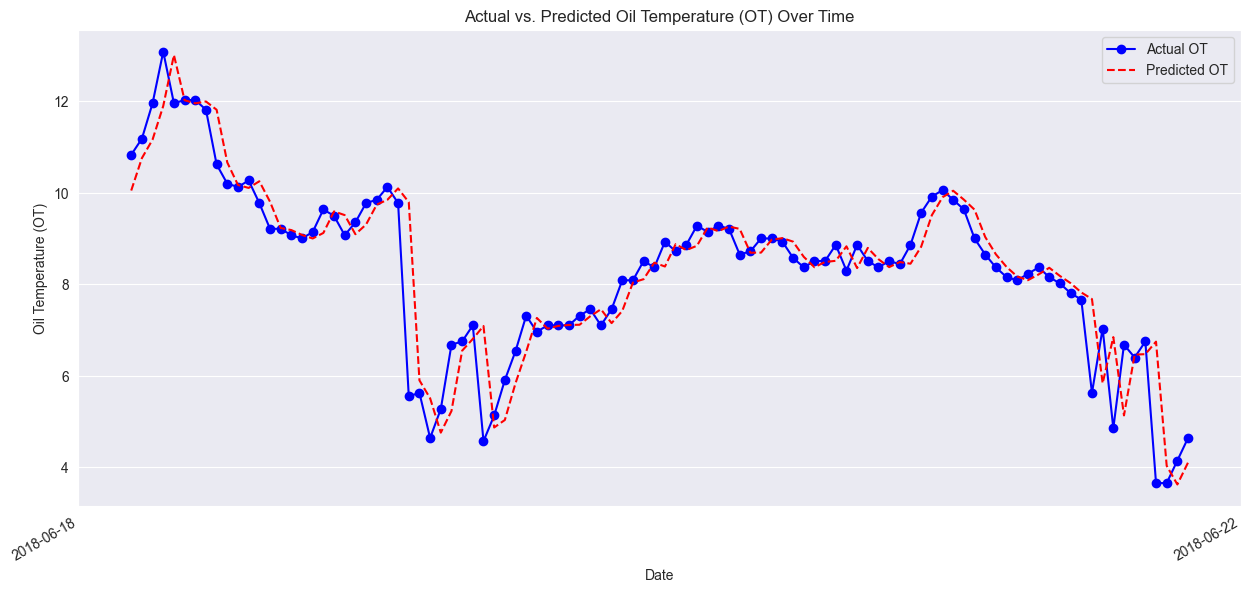

In [226]:

# Sample DataFrame 'comparison_df' columns: 'Date', 'Actual', 'Predicted'
# Ensure 'Date' is in datetime format; if not, convert it
comparison_df['date'] = pd.to_datetime(comparison_df['date'])

# Plotting
plt.figure(figsize=(15, 7))  # Set the figure size for better readability
plt.plot(comparison_df['date'], comparison_df['Actual'], label='Actual OT', color='blue', marker='o')
plt.plot(comparison_df['date'], comparison_df['Predicted'], label='Predicted OT', color='red', linestyle='--')

# Formatting the plot
plt.title('Actual vs. Predicted Oil Temperature (OT) Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Adjust interval for better readability
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [224]:
mae = mean_absolute_error(actuals, preds)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.4759785771369932
